# Three Level System
System in $\Lambda$ configuration, states |A>, |B> with energies $\omega_A$, $\omega_B$ and a common excited state |E> with energy $\omega_E$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [32]:
Gamma = 1
Gamma_A = Gamma_B = Gamma/2
Rabi_p = Rabi_c = 2*Gamma
Delta_p = Delta_c = 0
omega_E = 0


def bloch_fun_threelevel(t, rho):
    r_ee = rho[-1]
    r_ae = rho[2]
    r_be = rho[5]
    r_ea = rho[6]
    r_eb = rho[7]
    rho = rho.reshape([3,3])
    H = np.array([[omega_E-Delta_p, 0, -Rabi_p/2],
              [0, omega_E-Delta_c, -Rabi_c/2],
              [-Rabi_p/2, -Rabi_c/2, omega_E]])
    L = np.array([[Gamma_A*r_ee, 0, -(Gamma_A+Gamma_B)*r_ae/2],
             [0, Gamma_B*r_ee, -(Gamma_A+Gamma_B)*r_be/2],
             [-(Gamma_A+Gamma_B)*r_ea/2, -(Gamma_A+Gamma_B)*r_eb/2, -(Gamma_A+Gamma_B)*r_ee]])
    return (-1j*(H@rho-rho@H) + L).flatten()

In [33]:
%%time
sol = solve_ivp(bloch_fun_threelevel, [0,40], np.array([1,0,0,0,0,0,0,0,0], dtype = complex), method = 'BDF', vectorized = False,
                max_step = 1e-1)

Wall time: 189 ms


C:\Users\Olivier\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Olivier\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Olivier\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


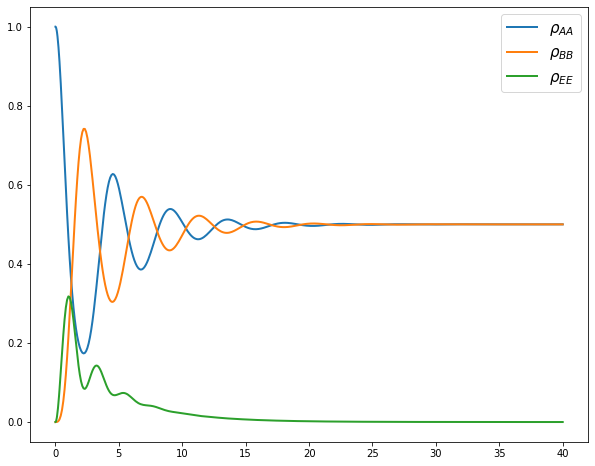

In [34]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(sol.t, sol.y[0], label = r'$\rho_{AA}$', lw = 2)
ax.plot(sol.t, sol.y[4], label = r'$\rho_{BB}$', lw = 2)
ax.plot(sol.t, sol.y[8], label = r'$\rho_{EE}$', lw = 2)
# ax.plot(sol.t, sol.y[[0,4,8]].sum(axis = 0), lw = 2)
ax.legend(fontsize = 15)

## Defining classes for solving Bloch Equations

In [5]:
import networkx
import numpy as np
from sympy import symbols, Symbol, simplify, conjugate, solve, diff
from sympy.matrices import zeros, ones, eye
from sympy import Matrix, MatrixSymbol
from sympy.functions.elementary.exponential import exp as symb_exp
from sympy import conjugate

In [6]:
class Hamiltonian:
    def __init__(self, levels):
        """
        """
        # total number of states
        self.levels = levels
        
        # defining the symbolic Hamiltonian matrix
        self.hamiltonian = zeros(levels, levels)
        
        # defining the couplings and rabi rate matrices
        # couplings contains the frequencies between levels
        # rabi contains the rabi rates of the couplings between levels
        self.couplings = zeros(levels, levels)
        self.rabi = zeros(levels, levels)
        
        # level detunings list
        self.detunings = []
        
        # numer of state couplings from an initial level
        self.cpl = np.zeros([levels,1])
        
        # frequencies list
        self.frequencies = []
        
        # energies list
        self.energies = self.hamiltonian.diagonal()
        
        # by default no zero energy defined
        self.zero_energy = None
        
    def defineZero(self,zero_energy):
        """
        Defining the zero level energy
        
        Parameters:
        zero_energy : state Symbol() which to set to zero
        """
        if not zero_energy in self.energies.free_symbols:
            raise AssertionError('Specified energy not in any of the energy levels.')
        self.zero_energy = zero_energy
        self.transformed = self.transformed.subs(zero_energy, 0)
    
    def addEnergies(self,energies):
        """
        Adding energy levels to the Hamiltonian
        
        Parameters:
        energies : list of state Symbol() which define the energy levels
        """
        if not len(energies) == self.levels:
            raise AssertionError('Not all energies specified.')
            
        # energies are on the diagonal of the Hamiltonian matrix
        for idx, energy in enumerate(energies):
            self.hamiltonian[idx,idx] = energy
        self.energies = self.hamiltonian.diagonal()
    
    def addCoupling(self, initial_state, final_state, rabi_rate, omega):
        """
        Add a coupling between two states
        
        Parameters:
        initial_state  : initial coupled state
        final_state    : final coupled state
        rabi_rate      : rabi rate of coupling between initial and final, Symbol
        omega          : requency of coupling between initial and final, Symbol
        """
        if (initial_state > self.hamiltonian.shape[0]) or (final_state > self.hamiltonian.shape[0]):
            raise AssertionError('Specified state exceeds size of Hamiltonian')
        
        # setting the frequency and rabi rate of the coupling to the symbolic matrices
        self.couplings[initial_state, final_state] = omega
        self.rabi[initial_state, final_state]      = rabi_rate
        
        # adding the coupling frequency to the frequencies list if not already present
        if omega not in self.frequencies:
            self.frequencies.append(omega)

        # adding the appropriote terms to the symbolic Hamiltonian matrix
        t = Symbol('t', real = True)
        self.hamiltonian[initial_state, final_state] = -rabi_rate/2*symb_exp(1j*omega*t)
        self.hamiltonian[final_state, initial_state] = -conjugate(rabi_rate)/2*symb_exp(-1j*omega*t)
        # incrementing the number of couplings counter from a specific initial state
        self.cpl[initial_state] += 1
        
    def addPolyCoupling(self, initial_state, final_state, rabi_rate, omega):
        """
        """
        if (inital_state > self.levels) or (final_state > self.levels):
            raise AssertionError('Specified state exceeds size of Hamiltonian')
        
        self.couplings[initial_state, final_state] = omega
        self.rabi[initial_state, final_state]      = rabi_rate

        if omega not in self.frequencies:
            self.frequencies.append(omega)

        t = Symbol('t', real = True)
        self.hamiltonian[initial_state, final_state] -= rabi_rate/2*symb_exp(1j*omega*t)
        self.hamiltonian[final_state, initial_state] -= conjugate(rabi_rate)/2*symb_exp(-1j*omega*t)
        self.cpl[initial_state] += 1
    
    def defineStateDetuning(self, initial_state, final_state, detuning):
        """
        Adding a state detuning, requires that self.transformed is defined
        
        Paramters:
        initial_state : initial coupled state
        final_state   : final coupled state
        detuning      : state detuning, Symbol
        """
        if detuning in self.detunings:
            raise AssertionError('Detuning already defined.')
        
        # check if the coupling for which the state detuning is requested exists
        if (self.couplings[initial_state, final_state] == 0) and \
           (self.couplings[final_state, initial_state] == 0):
            raise AssertionError('No coupling between states')
        
        # couplings are defined as initial->final; grab non-zero frequency from initial->final or final->initial
        # (accounts for user error in specifying the detuning initial and final state)
        w = self.couplings[initial_state, final_state]
        if w == 0:
            w = self.couplings[final_state, initial_state]
            
        # adding the detuning the the transformed matrix
        self.transformed = self.transformed.subs(w,self.hamiltonian[final_state,final_state] - self.hamiltonian[initial_state, initial_state] - detuning)
        
        # if the zero_energy is added via the state detuning, set it to zero
        if self.zero_energy:
            self.transformed = self.transformed.subs(self.zero_energy, 0)
        
        # append the detuning to the detunings list
        self.detunings.append([self.hamiltonian[initial_state, initial_state], 
                                                self.hamiltonian[final_state, final_state],
                                                detuning, w])
        
    def defineEnergyDetuning(self, inital_energy, final_energy, detuning, omega):
        """
        """
        if detuning in self.detunings:
            raise AssertionError('Detuning already defined.')
        
        if omega not in self.frequencies:
            raise AssertionError('Coupling does not exist')
        
        self.transformed = self.transformed.subs(omega, final_energy - initial_energy - detuning)
        
        if self.zero_energy:
            self.transformed = self.transformed.subs(self.zero-energy, 0)
        
        self.detunings.append([initial_energy, final_energy, detuning, omega])
        
        
    def eqnTransform(self):
        """
        Calculate the rotational wave approximation by solving a system of equations, only usable if 
        the number of couplings does not exceed the number of states
        """
        A = symbols(f'a0:{self.levels}')
        
        Eqns = []
        for i in range(len(A)):
            for j in range(len(A)):
                if self.couplings[i,j] != 0:
                    Eqns.append(self.couplings[i,j] - (A[i] - A[j]))
                
        sol = solve(Eqns, A)
        free_params = [value for value in A if value not in list(sol.keys())]
        for free_param in free_params:
            for key,val in sol.items():
                sol[key] = val.subs(free_param, 0)
           
        
        T = zeros(*self.hamiltonian.shape)
        for i in range(self.hamiltonian.shape[0]):
            try:
                T[i,i] = symb_exp(1j*sol[Symbol(f'a{i}')]*Symbol('t', real = True))
            except KeyError:
                T[i,i] = 1
        self.T = T
        
        self.transformed = T.adjoint()@self.hamiltonian@T-1j*T.adjoint()@diff(T,Symbol('t', real = True))
        self.transformed = simplify(self.transformed)
        
        for i in range(self.levels):
            for j in range(i+1,self.levels):
                if self.transformed[i,j] != 0:
                    val = self.transformed[i,j]*2/self.rabi[i,j]
                    if val not in [-1,1]:
                        raise AssertionError('Could not find unitary transformation')  \
    
    def shortestCouplingPath(self, graph, initial_state):
        """
        """
        # find the indices of the states which are defined as the zero_energy
        indices_zero_energy = np.where(np.array(self.energies) == self.zero_energy)[1]
        if indices_zero_energy.size == 0:
            return 0
        
        # get the first succesful shortest path from the initial state to a state with zero_energy
        for idx in indices_zero_energy:
            shortest_path = nx.algorithms.shortest_path(graph, source=initial_state, target = idx, weight = 'weight')
            if shortest_path:
                break
        
        print(initial_state, shortest_path)
                        
        # calculate the total coupling phase between the initial state and final state
        phase = 0
        for j in range(len(shortest_path)-1):
            start, stop = shortest_path[j:j+2]
            if self.couplings[start,stop] != 0:
                phase += self.couplings[start, stop]
            else:
                phase -= self.couplings[stop, start]
        return phase
    
    def generalTransform(self, graph):
        """
        """
        if not self.zero_energy:
            raise AssertionError('Zero energy has to be specified for this transformation method.')
        
        t = Symbol('t', real = True)
        
        T = eye(self.levels)
        for i in range(self.levels):
            phase = self.shortestCouplingPath(graph, i)
            T[i,i] = T[i,i]*symb_exp(1j*phase*t)
        T = simplify(T)
        
        self.transformed = T.adjoint()@self.hamiltonian@T-1j*T.adjoint()@diff(T,Symbol('t', real = True))
        
        if self.detunings:
            print(self.detunings)
            for i in range(len(self.detunings)):
                detuning = self.detunings[i]
                self.transformed = self.transformed.subs(detuning[3], detuning[1] - detuning[0] - detuning[2])

        if self.zero_energy:
            self.transformed = self.transformed.subs(self.zero_energy, 0)
        
        self.T = T
    
    def findDarkStates(self, ground_states, excited_states):
        if any(ground_state in excited_states for ground_state in ground_states):
            raise AssertionError('State can not be both ground and excited.')
        
        M = self.transformed[ground_states, excited_states].adjoint().as_mutable()
        for idx in range(len(excited_states)):
            M[idx,:] /= M[idx,:].norm()
        bright_states = M
        dark_states = M.nullspace()[0]
        return bright_states, dark_states

In [8]:
wa = Symbol(u'\u03C9_A', real = True)
wb = Symbol(u'\u03C9_B', real = True)
we = Symbol(u'\u03C9_E', real = True)

wp = Symbol(u'\u03C9_p', real = True)
Wp = Symbol(u'\u03A9_p', real = True)
wc = Symbol(u'\u03C9_c', real = True)
Wc = Symbol(u'\u03A9_c', real = True)

dp = Symbol(u'\u0394_p', real = True)
dc = Symbol(u'\u0394_c', real = True)

ham = Hamiltonian(3)
ham.addEnergies([wa, wb, we])
ham.addCoupling(0,2,Wp,wp)
ham.addCoupling(1,2,Wc,wc)
ham.eqnTransform()
ham.defineZero(we)
ham.defineStateDetuning(0,2,dp)
ham.defineStateDetuning(1,2,dc)

In [9]:
ham.findDarkStates([0,1],[2])[0]

Matrix([[-Ω_p/(2*sqrt(Ω_c**2/4 + Ω_p**2/4)), -Ω_c/(2*sqrt(Ω_c**2/4 + Ω_p**2/4))]])

In [11]:
ham.findDarkStates([0,1],[2])[1]

Matrix([
[-Ω_c/Ω_p],
[       1]])

In [12]:
ham.hamiltonian

Matrix([
[                     ω_A,                        0, -Ω_p*exp(1.0*I*t*ω_p)/2],
[                       0,                      ω_B, -Ω_c*exp(1.0*I*t*ω_c)/2],
[-Ω_p*exp(-1.0*I*t*ω_p)/2, -Ω_c*exp(-1.0*I*t*ω_c)/2,                     ω_E]])

In [13]:
ham.transformed

Matrix([
[-1.0*Δ_p,        0, -Ω_p/2],
[       0, -1.0*Δ_c, -Ω_c/2],
[  -Ω_p/2,   -Ω_c/2,      0]])

In [14]:
ham.T

Matrix([
[exp(1.0*I*t*ω_p),                0, 0],
[               0, exp(1.0*I*t*ω_c), 0],
[               0,                0, 1]])

In [15]:
ham.generalTransform(bgraph.coupling_graph)

NameError: name 'bgraph' is not defined

In [16]:
simplify(ham.transformed)

Matrix([
[-1.0*Δ_p,        0, -Ω_p/2],
[       0, -1.0*Δ_c, -Ω_c/2],
[  -Ω_p/2,   -Ω_c/2,      0]])

In [17]:
ham.T

Matrix([
[exp(1.0*I*t*ω_p),                0, 0],
[               0, exp(1.0*I*t*ω_c), 0],
[               0,                0, 1]])

In [18]:
print(bloch.equations)

NameError: name 'bloch' is not defined

In [20]:
from sympy import sqrt, Rational, Function, dsolve

def anti_commute(A,B):
    """
    """
    return A@B+B@A

def commute(A,B):
    """
    """
    return A@B-B@A

class Dissipator:
    def __init__(self, levels):
        """
        """
        self.density_matrix = zeros(levels, levels)
        self.dissipator = zeros(levels, levels)
        self.branching = zeros(levels, levels)
        self.decay_rate = zeros(levels, 1)
        self.levels = levels
        
        self.generateDensityMatrix()
        
    def generateDensityMatrix(self):
        """
        """
        self.density_matrix = zeros(self.levels, self.levels)
        t = Symbol('t', real = True)
        for i in range(self.levels):
            for j in range(i,self.levels):
                if i == j:
                    self.density_matrix[i,j] = Function(u'\u03C1{0}{1}'.format(chr(0x2080+i), chr(0x2080+j)))(t)
                else:
                    self.density_matrix[i,j] = Function(u'\u03C1{0}{1}'.format(chr(0x2080+i), chr(0x2080+j)))(t)
                    self.density_matrix[j,i] = conjugate(Function(u'\u03C1{0}{1}'.format(chr(0x2080+i), chr(0x2080+j)))(t))
        
    def addDecay(self, initial_state, final_state, gamma):
        """
        """
        if (initial_state >= self.levels) or (final_state >= self.levels):
            raise AssertionError('Specified state exceeds number of levels.')
        if initial_state == final_state:
            raise AssertionError('State cannot decay into itself.')
            
        G = zeros(self.levels, self.levels)
        G[final_state, initial_state] = sqrt(gamma)
        self.dissipator -= Rational(1/2) * anti_commute(G.T@G, self.density_matrix) - G@self.density_matrix@G.T
        self.dissipator = simplify(self.dissipator)
        
        # update decay rates
        decay_rate_old = self.decay_rate[initial_state]
        decay_rate_new = decay_rate_old + gamma
        self.decay_rate[initial_state] += gamma
        
        for i in range(self.levels):
            if i == final_state:
                self.branching[initial_state, i] = (self.branching[initial_state, i]*decay_rate_old+gamma)/decay_rate_new
            else:
                self.branching[initial_state, i] = (self.branching[initial_state, i]*decay_rate_old)/decay_rate_new

In [21]:
ga = Symbol('\u0393_A', real = True)
gb = Symbol('\u0393_B', real = True)
dis = Dissipator(3)
dis.addDecay(2,0,ga)
dis.addDecay(2,1,gb)

In [22]:
dis.density_matrix

Matrix([
[           ρ₀₀(t),            ρ₀₁(t), ρ₀₂(t)],
[conjugate(ρ₀₁(t)),            ρ₁₁(t), ρ₁₂(t)],
[conjugate(ρ₀₂(t)), conjugate(ρ₁₂(t)), ρ₂₂(t)]])

In [23]:
dis.branching

Matrix([
[              0,               0, 0],
[              0,               0, 0],
[Γ_A/(Γ_A + Γ_B), Γ_B/(Γ_A + Γ_B), 0]])

In [19]:
dis.decay_rate

Matrix([
[        0],
[        0],
[Γ_A + Γ_B]])

In [20]:
dis.dissipator

Matrix([
[                      Γ_A*ρ₂₂(t),                                0, -(Γ_A + Γ_B)*ρ₀₂(t)/2],
[                               0,                       Γ_B*ρ₂₂(t), -(Γ_A + Γ_B)*ρ₁₂(t)/2],
[-(Γ_A + Γ_B)*conjugate(ρ₀₂(t))/2, -(Γ_A + Γ_B)*conjugate(ρ₁₂(t))/2,   -(Γ_A + Γ_B)*ρ₂₂(t)]])

In [24]:
from sympy import Eq, solve, dsolve

def flatten(l):
    """
    """
    return [item for sublist in l for item in sublist]

class BlochEquations:
    def __init__(self, hamiltonian, dissipator):
        """
        """
        self.levels = dissipator.levels
        self.hamiltonian = hamiltonian.transformed
        self.dissipator = dissipator.dissipator
        self.density_matrix = dissipator.density_matrix
        
        self.generateEquations()
        self.generateSteadyStateDensityMatrix()
        self.generateEquationsSteadyState()
        
    def generateSteadyStateDensityMatrix(self):
        """
        """
        density_matrix = zeros(*self.hamiltonian.shape)
        for i in range(self.hamiltonian.shape[0]):
            for j in range(i,self.hamiltonian.shape[0]):
                if i == j:
                    density_matrix[i,j] = Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), chr(0x2080+j)))
                else:
                    density_matrix[i,j] = Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), chr(0x2080+j)))
                    density_matrix[j,i] = conjugate(Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), chr(0x2080+j))))
        self.density_matrix_steady_state = density_matrix
    
    def generateEquations(self):
        """
        """
        self.equations = Eq(diff(self.density_matrix),simplify(-1j*commute(self.hamiltonian,self.density_matrix)+self.dissipator))
    
    def generateEquationsSteadyState(self):
        """
        """
        self.equations_steady_state = Eq(zeros(self.levels, self.levels),
                                         simplify(-1j*commute(self.hamiltonian,self.density_matrix_steady_state)+self.dissipator))
        for i in range(self.levels):
            for j in range(self.levels):
                self.equations_steady_state = self.equations_steady_state.replace(self.density_matrix[i,j],
                                                                                  self.density_matrix_steady_state[i,j])
    def solveSteadyState(self, replacements):
        """
        """
        eqns_rhs = self.equations_steady_state.rhs.subs(replacements)
        eqns_rhs = flatten(eqns_rhs.tolist())
        eqns_rhs.append(self.density_matrix_steady_state.trace()-1)
        sol = solve(eqns_rhs, bloch.density_matrix_steady_state)
        return sol


In [25]:
bloch = BlochEquations(ham, dis)

In [26]:
bloch.equations

Eq(Matrix([
[           Derivative(ρ₀₀(t), t),            Derivative(ρ₀₁(t), t), Derivative(ρ₀₂(t), t)],
[conjugate(Derivative(ρ₀₁(t), t)),            Derivative(ρ₁₁(t), t), Derivative(ρ₁₂(t), t)],
[conjugate(Derivative(ρ₀₂(t), t)), conjugate(Derivative(ρ₁₂(t), t)), Derivative(ρ₂₂(t), t)]]), Matrix([
[                                                                            Γ_A*ρ₂₂(t) + 0.5*I*Ω_p*(-ρ₀₂(t) + conjugate(ρ₀₂(t))),                                     I*(-1.0*Δ_c*ρ₀₁(t) + 1.0*Δ_p*ρ₀₁(t) - 0.5*Ω_c*ρ₀₂(t) + 0.5*Ω_p*conjugate(ρ₁₂(t))),                   -(Γ_A + Γ_B)*ρ₀₂(t)/2 + I*(2.0*Δ_p*ρ₀₂(t) - Ω_c*ρ₀₁(t) - Ω_p*ρ₀₀(t) + Ω_p*ρ₂₂(t))/2],
[                          I*(1.0*Δ_c*conjugate(ρ₀₁(t)) - 1.0*Δ_p*conjugate(ρ₀₁(t)) + 0.5*Ω_c*conjugate(ρ₀₂(t)) - 0.5*Ω_p*ρ₁₂(t)),                                                                  Γ_B*ρ₂₂(t) + 0.5*I*Ω_c*(-ρ₁₂(t) + conjugate(ρ₁₂(t))),        -(Γ_A + Γ_B)*ρ₁₂(t)/2 + I*(2.0*Δ_c*ρ₁₂(t) - Ω_c*ρ₁₁(t) + Ω_c*ρ₂₂(t) - Ω_p*conjugate(ρ₀₁

In [31]:
bloch.equations_steady_state.rhs.subs(replacements)

Matrix([
[                            0.5*ρ₂₂ + 1.0*I*(-ρ₀₂ + conjugate(ρ₀₂)),                        I*(-1.0*ρ₀₂ + 1.0*conjugate(ρ₁₂)),                                -0.5*ρ₀₂ + I*(-2*ρ₀₀ - 2*ρ₀₁ + 2*ρ₂₂)/2],
[                                  I*(-1.0*ρ₁₂ + 1.0*conjugate(ρ₀₂)),                  0.5*ρ₂₂ + 1.0*I*(-ρ₁₂ + conjugate(ρ₁₂)),                     -0.5*ρ₁₂ + I*(-2*ρ₁₁ + 2*ρ₂₂ - 2*conjugate(ρ₀₁))/2],
[-I*(-2.0*ρ₀₀ + 2.0*ρ₂₂ - 2.0*conjugate(ρ₀₁))/2 - 0.5*conjugate(ρ₀₂), -I*(-2.0*ρ₀₁ - 2.0*ρ₁₁ + 2.0*ρ₂₂)/2 - 0.5*conjugate(ρ₁₂), -1.0*ρ₂₂ + 0.5*I*(2*ρ₀₂ + 2*ρ₁₂ - 2*conjugate(ρ₀₂) - 2*conjugate(ρ₁₂))]])

In [27]:
%%time
replacements = [(dp, 0),
                (Wc, 2), 
                (Wp, 2), 
                (dc, 0),
                (gb, ga), 
                (ga, 1/2)]
sol = bloch.solveSteadyState(replacements)

Wall time: 444 ms


In [28]:
sol

{ρ₁₁: 0.500000000000000,
 conjugate(ρ₁₂): 0.0,
 ρ₀₁: -0.500000000000000,
 conjugate(ρ₀₁): -0.500000000000000,
 ρ₂₂: 0.0,
 ρ₁₂: 0.0,
 ρ₀₀: 0.500000000000000,
 conjugate(ρ₀₂): 0.0,
 ρ₀₂: 0.0}

In [34]:
for key, value in sol.items():
    print(key, value)

ρ₁₁ 0.500000000000000
conjugate(ρ₁₂) 0.0
ρ₀₁ -0.500000000000000
conjugate(ρ₀₁) -0.500000000000000
ρ₂₂ 0.0
ρ₁₂ 0.0
ρ₀₀ 0.500000000000000
conjugate(ρ₀₂) 0.0
ρ₀₂ 0.0


## 4 Level System

In [102]:
wa = Symbol(u'\u03C9_A', real = True)
wb = Symbol(u'\u03C9_B', real = True)
we1 = Symbol(u'\u03C9_{E1}', real = True)
we2 = Symbol(u'\u03C9_{E2}', real = True)

wc1 = Symbol(u'\u03C9_{c1}', real = True)
Wc1 = Symbol(u'\u03A9_{c1}', real = True)
wp = Symbol(u'\u03C9_p', real = True)
Wp = Symbol(u'\u03A9_p', real = True)
wc2 = Symbol(u'\u03C9_{c2}', real = True)
Wc2 = Symbol(u'\u03A9_{c2}', real = True)

dp = Symbol(u'\u0394_p', real = True)
dc1 = Symbol(u'\u0394_{c1}', real = True)
dc2 = Symbol(u'\u0394_{c2}', real = True)

ham = Hamiltonian(4)
ham.addEnergies([wa, wb, we1, we2])
ham.addCoupling(0,2,Wc1,wc1)
ham.addCoupling(1,2,Wp,wp)
ham.addCoupling(1,3,Wc2,wc2)
ham.eqnTransform()
ham.defineZero(we2)
ham.defineStateDetuning(0,2,dc1)
ham.defineStateDetuning(1,2,dp)
ham.defineStateDetuning(1,3,dc2)

In [103]:
ham.hamiltonian

Matrix([
[                           ω_A,                              0, -Ω_{c1}*exp(1.0*I*t*ω_{c1})/2,                             0],
[                             0,                            ω_B,       -Ω_p*exp(1.0*I*t*ω_p)/2, -Ω_{c2}*exp(1.0*I*t*ω_{c2})/2],
[-Ω_{c1}*exp(-1.0*I*t*ω_{c1})/2,       -Ω_p*exp(-1.0*I*t*ω_p)/2,                        ω_{E1},                             0],
[                             0, -Ω_{c2}*exp(-1.0*I*t*ω_{c2})/2,                             0,                        ω_{E2}]])

In [104]:
ham.T

Matrix([
[exp(1.0*I*t*(-ω_p + ω_{c1} + ω_{c2})),                   0,                            0, 0],
[                                    0, exp(1.0*I*t*ω_{c2}),                            0, 0],
[                                    0,                   0, exp(1.0*I*t*(-ω_p + ω_{c2})), 0],
[                                    0,                   0,                            0, 1]])

In [105]:
ham.transformed

Matrix([
[1.0*Δ_p - 1.0*Δ_{c1} - 1.0*Δ_{c2},           0,            -Ω_{c1}/2,         0],
[                                0, -1.0*Δ_{c2},               -Ω_p/2, -Ω_{c2}/2],
[                        -Ω_{c1}/2,      -Ω_p/2, 1.0*Δ_p - 1.0*Δ_{c2},         0],
[                                0,   -Ω_{c2}/2,                    0,         0]])

In [106]:
ga = Symbol('\u0393_A', real = True)
gb1 = Symbol('\u0393_{B1}', real = True)
gb2 = Symbol('\u0393_{B2}', real = True)
dis = Dissipator(4)
dis.addDecay(2,0,ga)
dis.addDecay(2,1,gb1)
dis.addDecay(3,1,gb2)

In [107]:
dis.dissipator

Matrix([
[                         Γ_A*ρ₂₂(t),                                   0,                     -(Γ_A + Γ_{B1})*ρ₀₂(t)/2,                  -Γ_{B2}*ρ₀₃(t)/2],
[                                  0,       Γ_{B1}*ρ₂₂(t) + Γ_{B2}*ρ₃₃(t),                     -(Γ_A + Γ_{B1})*ρ₁₂(t)/2,                  -Γ_{B2}*ρ₁₃(t)/2],
[-(Γ_A + Γ_{B1})*conjugate(ρ₀₂(t))/2, -(Γ_A + Γ_{B1})*conjugate(ρ₁₂(t))/2,                       -(Γ_A + Γ_{B1})*ρ₂₂(t), -(Γ_A + Γ_{B1} + Γ_{B2})*ρ₂₃(t)/2],
[        -Γ_{B2}*conjugate(ρ₀₃(t))/2,         -Γ_{B2}*conjugate(ρ₁₃(t))/2, -(Γ_A + Γ_{B1} + Γ_{B2})*conjugate(ρ₂₃(t))/2,                    -Γ_{B2}*ρ₃₃(t)]])

In [108]:
bloch = BlochEquations(ham, dis)

In [109]:
bloch.equations

Eq(Matrix([
[           Derivative(ρ₀₀(t), t),            Derivative(ρ₀₁(t), t),            Derivative(ρ₀₂(t), t), Derivative(ρ₀₃(t), t)],
[conjugate(Derivative(ρ₀₁(t), t)),            Derivative(ρ₁₁(t), t),            Derivative(ρ₁₂(t), t), Derivative(ρ₁₃(t), t)],
[conjugate(Derivative(ρ₀₂(t), t)), conjugate(Derivative(ρ₁₂(t), t)),            Derivative(ρ₂₂(t), t), Derivative(ρ₂₃(t), t)],
[conjugate(Derivative(ρ₀₃(t), t)), conjugate(Derivative(ρ₁₃(t), t)), conjugate(Derivative(ρ₂₃(t), t)), Derivative(ρ₃₃(t), t)]]), Matrix([
[                                                                                                             Γ_A*ρ₂₂(t) + 0.5*I*Ω_{c1}*(-ρ₀₂(t) + conjugate(ρ₀₂(t))),                                                                               I*(-1.0*Δ_p*ρ₀₁(t) + 1.0*Δ_{c1}*ρ₀₁(t) - 0.5*Ω_p*ρ₀₂(t) + 0.5*Ω_{c1}*conjugate(ρ₁₂(t)) - 0.5*Ω_{c2}*ρ₀₃(t)),                           -(Γ_A + Γ_{B1})*ρ₀₂(t)/2 + I*(-Ω_p*ρ₀₁(t) - Ω_{c1}*ρ₀₀(t) + Ω_{c1}*ρ₂₂(t) + 2.0*(Δ_p - Δ_

In [110]:
%%time
replacements = [(dc1,0),
                (dc2,0),
                (dp,0),
                (ga,1/2), 
                (gb1,1/2), 
                (gb2,1),
                (Wc1,2),
                (Wc2,2),
                (Wp,2)]
sol = bloch.solveSteadyState(replacements)

Wall time: 1.35 s


In [111]:
for s in bloch.density_matrix_steady_state.diagonal():
    print(s, ':', f'{sol[s]:.3f}')

ρ₀₀ : 0.260
ρ₁₁ : 0.308
ρ₂₂ : 0.224
ρ₃₃ : 0.208


In [39]:
%%time
from tqdm.notebook import tqdm

s = bloch.density_matrix_steady_state.diagonal()[0]
dpnumerics = np.arange(-10,10,0.5)
y = []
for dpnumeric in tqdm(dpnumerics):
    replacements = [(dc1,0),
                (dc2,0),
                (dp,dpnumeric),
                (ga,1/2), 
                (gb1,1/2), 
                (gb2,1),
                (Wc1,2),
                (Wc2,2),
                (Wp,2)]
    sol = bloch.solveSteadyState(replacements)
    y.append(sol[s])


Wall time: 5min 16s


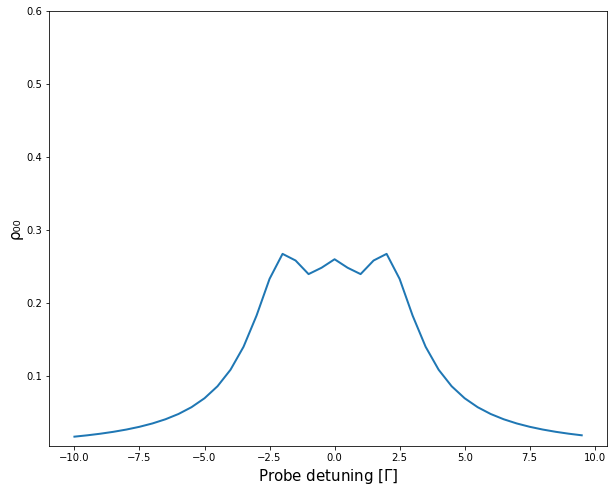

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,8))
ax.plot(dpnumerics, y, lw = 2)
ax.set_ylim(ymax = 0.6)
ax.set_xlabel(r'Probe detuning [$\Gamma$]', fontsize = 15)
ax.set_ylabel(bloch.density_matrix_steady_state.diagonal()[0], fontsize = 15);

In [45]:
from sympy import linear_eq_to_matrix

replacements = [(dc1,0),
                (dc2,0),
                (ga,1/2), 
                (gb1,1/2), 
                (gb2,1),
                (Wc1,2),
                (Wc2,2),
                (Wp,2)]    
eqns_rhs = bloch.equations_steady_state.rhs.subs(replacements)
eqns_rhs = flatten(eqns_rhs.tolist())
eqns_rhs[0] += bloch.density_matrix_steady_state.trace()-1
for i in range(bloch.levels):
    for j in range(i,bloch.levels):
        tmp = Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), chr(0x2080+j)))
        tmp1 = Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+j), chr(0x2080+i)))
        for idx in range(len(eqns_rhs)):
            eqns_rhs[idx] = eqns_rhs[idx].subs(conjugate(tmp), tmp1)
syms = []
for i in range(bloch.levels):
    for j in range(bloch.levels):
        syms.append(Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), chr(0x2080+j))))
matrix_eq = linear_eq_to_matrix(eqns_rhs, syms)

In [46]:
from sympy import lambdify

a = lambdify(dp, matrix_eq[0], 'numpy')
b = np.array(matrix_eq[1]).astype(float)

In [49]:
from tqdm import tqdm

dpnumerics = np.arange(-10,10,1e-2)
y = np.empty([len(syms), len(dpnumerics)], dtype = complex)

for idx, dpnumeric in tqdm(enumerate(dpnumerics)):
    sol = np.linalg.solve(a(dpnumeric),b)
    y[:,idx] = sol[:,0]

2000it [00:00, 12987.19it/s]


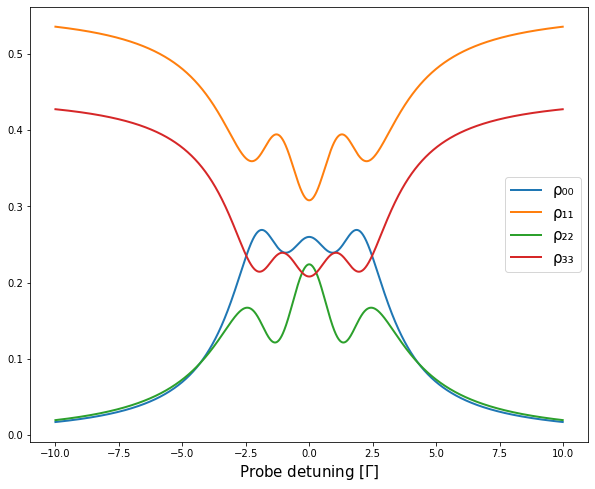

In [50]:
fig, ax = plt.subplots(figsize = (10,8))

for symbol_idx in [0,5,10,15]:
    ax.plot(dpnumerics, y[symbol_idx,:].real, lw = 2, label = syms[symbol_idx])
    
ax.legend(fontsize = 15)
ax.set_xlabel(r'Probe detuning [$\Gamma$]', fontsize = 15);

In [25]:
import networkx as nx

class BlochGraph:
    def __init__(self, hamiltonian, dissipator):
        self.hamiltonian = hamiltonian.hamiltonian
        self.couplings = hamiltonian.couplings
        self.rabi = hamiltonian.rabi
        self.energies = hamiltonian.energies
        self.levels = hamiltonian.levels
        
        self.dissipator = dissipator.dissipator
        self.branching = dissipator.branching
        self.decay_rate = dissipator.decay_rate
        
        self.state_graph = self.createStateGraph()
        self.coupling_graph = self.createCouplingGraph()
                
    def createStateGraph(self):
        initial_nodes = []
        final_nodes = []
        weights = []
        labels = []
        
        for i in range(self.levels):
            for j in range(self.levels):
                if self.couplings[i,j] != 0:
                    initial_nodes.append(i)
                    final_nodes.append(j)
                    weights.append(1)
                    labels.append(str(self.rabi[i,j]))
        replacements = [(s,1) for s in self.branching.free_symbols]
        for i in range(self.levels):
            for j in range(self.levels):
                if self.branching[i,j] != 0:
                    initial_nodes.append(i)
                    final_nodes.append(j)
                    weights.append(float(self.branching[i,j].subs(replacements)))
                    labels.append(str(self.branching[i,j]*self.decay_rate[i]))
        
        graph = nx.DiGraph()
        for initial, final, weight, label in zip(initial_nodes, final_nodes, weights, labels):
            graph.add_edge(initial,final,weight=weight,label=label)
            
        node_labels = {node:{'label':r'${}$'.format(self.energies[node])} for node in graph.nodes}
        nx.classes.function.set_node_attributes(graph, node_labels)
        return graph
    
    def createCouplingGraph(self):
        graph = nx.Graph()
        for i in range(self.levels):
            for j in range(self.levels):
                if self.couplings[i,j] != 0:
                    graph.add_node(i, **{'label': self.energies[i]})
                    graph.add_node(j, **{'label': self.energies[j]})
                    graph.add_edge(i,j,**{'label': self.rabi[i,j]})
        return graph

In [26]:
bgraph = BlochGraph(ham, dis)

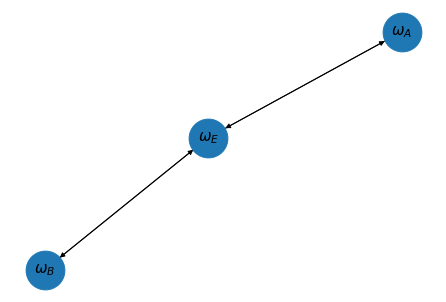

In [27]:
g = bgraph.state_graph
pos=nx.spring_layout(g)
nx.draw(g, pos, node_size = 1500)
nx.draw_networkx_labels(g,pos,labels = nx.get_node_attributes(g, 'label'),font_size=15);